# 0. Apoio

## 0.1. Bibliotecas

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib  import pyplot           as plt
from scipy.stats import chi2_contingency as chisq

## 0.2. Funções suporte

In [2]:
def tab_freq(data, var, ordem_var = False):    
    #freq abs
    data_summary = data.groupby(var).size().reset_index(name='freq_abs')
    
    #freq rel
    data_summary["freq_rel"] = (data.groupby(var).size().reset_index(name='counts')["counts"]/len(data))

    if ordem_var != False: 
        data_summary["order_var"] = data_summary[var].map( ordem_var )
        data_summary = data_summary.sort_values("order_var").reset_index()
    
    
    #freq acum
    sum_acum = 0 
    x1_sum_acum = []    
    for i in list(range(len(data_summary))):
             sum_acum = sum_acum + data_summary["freq_rel"][i]
             x1_sum_acum.append(sum_acum)

    data_summary["freq_acum"] = x1_sum_acum
    
    if ordem_var != False:
        data_summary = data_summary[[var,'freq_abs',"freq_rel","freq_acum"]]
    
    return data_summary

def tab_res_qtd(num_attributes):
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
    d7 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile(0.25) ) ).T
    d8 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile(0.75) ) ).T
    
    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, d7, d8] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', '1 quartil', '3 quartil']
    m
    
    return m

def tab_cont(data, var1, var2, ordem_var = False):
    aux1 = data.groupby([var1,var2]).size().reset_index(name="freq")
    aux1["freq_rel"] = aux1["freq"]/len(data)
    
    if ordem_var != False: 
        aux1["order_var"] = aux1[var2].map( ordem_var )
        aux1 = aux1.sort_values("order_var").reset_index()
        aux1 = aux1.drop(columns=["order_var"])
    
    aux2 = aux1.pivot(index=var1, columns=var2, values="freq")
    aux3 = aux1.pivot(index=var1, columns=var2, values="freq_rel")
    
    aux3.columns = aux3.columns + "_perc"
    
    aux = pd.concat([aux2, aux3], axis = 1)
    
    return aux

def qui_quadrado(data, var1, var2):
    obs_df = data.groupby([var1,var2]).size().reset_index(name="freq")    
    obs_df = obs_df.pivot(index=var1, columns=var2, values="freq")
    obs_df = np.matrix(obs_df)
    
    exp_var1 = data.groupby([var1]).size().reset_index(name="freq1")
    exp_var2 = data.groupby([var2]).size().reset_index(name="freq2")
    exp_var2["freq2"] = exp_var2["freq2"] / len(data)
    
    exp_var1 = np.matrix(exp_var1["freq1"])
    exp_var2 = np.matrix(exp_var2["freq2"])
    
    exp_tab = np.matmul(exp_var1.T,exp_var2)
    
    chisq_res = chisq(obs_df, exp_tab)
    
    return chisq_res[0]

def info_value(data,var1,var2, ordem_var = False):
    aux = tab_cont(data,var1,var2, ordem_var = ordem_var)
    aux.columns = ['nao','sim','nao_perc','sim_perc']
    aux = aux[['nao','sim']]
    aux['nao_perc'] = aux['nao']/ aux['nao'].sum()
    aux['sim_perc'] = aux['sim']/ aux['sim'].sum()
    aux['freq'] = aux['nao'] + aux['sim']
    aux['tx_sim'] = aux['sim']/aux['freq']
    aux['odds'] = aux['sim_perc']/aux['nao_perc']
    aux['ln_odds'] = np.log( aux['odds'] )
    aux['info_value'] = (aux['sim_perc'] - aux['nao_perc'])*aux['ln_odds']
    info_value = aux['info_value'].sum()
    
    return [info_value, aux]

def r_quad(data,var1,var2):
    var_tab = data.groupby(var1)[var2].agg('var').reset_index(name = var2)
    var_tab["freq"] = data.groupby(var1).size().reset_index(name = "Freq")["Freq"]
    var_tab["freq_rel"] = var_tab["freq"]/len(data[var1])
    var_pond = (var_tab["freq_rel"]*var_tab[var2]).reset_index(name = "var_pond")["var_pond"].sum()
    var_geral = data[var2].var()
    r_quad = 1 - var_pond/var_geral
    return r_quad

def plot_classe(data,var1,var2,classe):
    aux1 = data[(data[var2] == classe)]
    tamanho = len(aux1)
    aux1 = aux1.groupby(var1).size().reset_index(name = "freq")
    aux1["freq_rel"] = aux1["freq"]/tamanho
    aux1 = aux1.set_index(var1)
    plot = aux1.plot.pie(y = "freq_rel")
    return plot

# 1. Entendimento do negócio

## 1.1. Objetivo
* Reduzir o Turnover

## 1.2. Premissas

* O Turnover (rotatividade de funcionários) é um grande problema para as empresas. 
* Sempre que um funcionário deixa um determinado trabalho, a empresa perde dinheiro e tempo com novas entrevistas e treinamentos do novo funcionário.
* Isso sem falar da perda de produtividade do setor afetado por esse turnover. 
* empresa de Tecnologia, 
* o RH desta empresa catalogou informações de 1470 funcionários que deixaram ou permaneceram na companhia no último ano.

## 1.3. Risco envolvido
* Não diminuir o turnover
* Variaveis na base de dados não são suficientes para explicar o fenomeno
* Aumentar custos


## 1.4. Custos
* Trabalho Analista de dados
* Sempre que um funcionário deixa um determinado trabalho, a empresa perde dinheiro e tempo com novas entrevistas e treinamentos do novo funcionário

## 1.5. Critérios de sucesso
* Diminuir o turnover
* Não aumentar custos
* Não aumentar drasticamente o quadro de funcionários
* Concluir análise até dia 12/09


## 1.6. Planejamento
* Metodologia CRISP-DM
* Sprints semanais
* Entrega final 12/09/2021

# 2. Entendimento dos dados

## 2.1. Importando dados

In [3]:
data = pd.read_excel("../dados/base_rh.xlsx", sheet_name = "Base")

In [4]:
data.head()

,ID,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Estado_Civil,Salário,Faz_hora_extras?,Tempo_de_empresa
0,1,Sim,16,Viaja raramente,1,Ensino Técnico,Médio,M,Solteiro,5993,Sim,6
1,2,Não,49,Viaja frequentemente,8,Ensino Médio,Alto,H,Casado,5130,Não,10
2,3,Sim,28,Viaja raramente,2,Ensino Técnico,Muito Alto,H,Solteiro,2090,Sim,0
3,4,Não,33,Viaja frequentemente,3,Mestrado,Muito Alto,M,Casado,2909,Sim,8
4,5,Não,27,Viaja raramente,2,Ensino Médio,Baixo,H,Casado,3468,Não,2


## 2.2. Descrição dos dados

In [5]:
metadata = pd.read_excel("../dados/base_rh.xlsx", sheet_name = "Metadados")
metadata = metadata[["Variável","Descrição"]]
metadata

,Variável,Descrição
0,ID,Matrícula do funcionário
1,Funcionário_deixou_a_empresa,Marcação sem funcionário deixou a empresa rece...
2,Idade,Idade do funcionário
3,Frequência de Viagens,Frequência de viagens a trabalho do funcionário
4,Distância_do_trabalho,Distância em Km até o trabalho
5,Formação,Nível de formação
6,E-Sat,Satisfação com o clima organizacional
7,Gênero,Gênero do funcionário
8,Estado_Civil,Estado civil do funcionário
9,Salário,Salário mensal


### 2.2.0. Renomear variáveis

### 2.2.1. Dimensão dos dados

In [6]:
data.shape

(1470, 12)

### 2.2.2. Tipos de variáveis

In [7]:
data.dtypes

ID                               int64
Funcionário_deixou_a_empresa    object
Idade                            int64
Frequência de Viagens           object
Distância_do_trabalho            int64
Formação                        object
E-Sat                           object
Gênero                          object
Estado_Civil                    object
Salário                          int64
Faz_hora_extras?                object
Tempo_de_empresa                 int64
dtype: object

### 2.2.3. Sanity Check

#### 2.2.3.1. Check NA

#### 2.2.3.2. Fillout NA

#### 2.2.3.3. Change Data Types

## 2.3. Análise Exploratória

### 2.3.1. Análise Univariada

#### 2.3.1.1. Variáveis qualitativas

In [8]:
["Funcionário_deixou_a_empresa","Frequência de Viagens","Formação","E-Sat","Gênero","Estado_Civil","Faz_hora_extras?"]

['Funcionário_deixou_a_empresa',
 'Frequência de Viagens',
 'Formação',
 'E-Sat',
 'Gênero',
 'Estado_Civil',
 'Faz_hora_extras?']

In [9]:
#taxa de turnover 
tab_freq(data,"Funcionário_deixou_a_empresa")

,Funcionário_deixou_a_empresa,freq_abs,freq_rel,freq_acum
0,Não,1233,0.838776,0.838776
1,Sim,237,0.161224,1.000000


In [10]:
ordem_viagens = {"Não viaja":0, "Viaja raramente": 1, "Viaja frequentemente":2} 
tab_freq(data,"Frequência de Viagens", ordem_var = ordem_viagens)

,Frequência de Viagens,freq_abs,freq_rel,freq_acum
0,Não viaja,150,0.102041,0.102041
1,Viaja raramente,1043,0.709524,0.811565
2,Viaja frequentemente,277,0.188435,1.000000


In [11]:
ordem_formacao = {"Ensino Médio":0, "Ensino Técnico": 1, "Ensino Superior":2, "Mestrado":3, "Doutorado":4} 
tab_freq(data,"Formação",ordem_var = ordem_formacao)

,Formação,freq_abs,freq_rel,freq_acum
0,Ensino Médio,170,0.115646,0.115646
1,Ensino Técnico,282,0.191837,0.307483
2,Ensino Superior,572,0.389116,0.696599
3,Mestrado,398,0.270748,0.967347
4,Doutorado,48,0.032653,1.000000


In [12]:
ordem_esat = {"Baixo":0, "Médio": 1, "Alto":2, "Muito Alto":3} 
tab_freq(data,"E-Sat", ordem_var = ordem_esat)

,E-Sat,freq_abs,freq_rel,freq_acum
0,Baixo,284,0.193197,0.193197
1,Médio,287,0.195238,0.388435
2,Alto,453,0.308163,0.696599
3,Muito Alto,446,0.303401,1.000000


In [13]:
tab_freq(data,"Gênero")

,Gênero,freq_abs,freq_rel,freq_acum
0,H,882,0.6,0.6
1,M,588,0.4,1.0


In [14]:
tab_freq(data,"Estado_Civil")

,Estado_Civil,freq_abs,freq_rel,freq_acum
0,Casado,673,0.457823,0.457823
1,Divorciado,327,0.222449,0.680272
2,Solteiro,470,0.319728,1.000000


In [15]:
tab_freq(data,"Faz_hora_extras?")

,Faz_hora_extras?,freq_abs,freq_rel,freq_acum
0,Não,1054,0.717007,0.717007
1,Sim,416,0.282993,1.000000


#### 2.3.1.2. Variáveis quantitativas

In [16]:
num_data = data.select_dtypes( include=['int64', 'float64'] )
num_data = num_data.drop( columns=['ID'] )

tab_res_qtd(num_data)

,attributes,min,max,range,mean,median,std,skew,kurtosis,1 quartil,3 quartil
0,Idade,9.0,60.0,51.0,36.026531,35.0,9.292084,0.345953,-0.225185,29.0,42.0
1,Distância_do_trabalho,1.0,29.0,28.0,9.192517,7.0,8.104107,0.958118,-0.224833,2.0,14.0
2,Salário,1009.0,19999.0,18990.0,6502.931293,4919.0,4706.355165,1.369817,1.005233,2911.0,8379.0
3,Tempo_de_empresa,0.0,40.0,40.0,7.008163,5.0,6.124441,1.764529,3.935509,3.0,9.0


<AxesSubplot:ylabel='Tempo_de_empresa'>

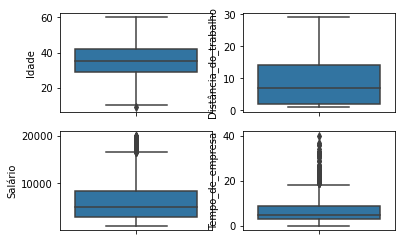

In [17]:
plt.subplot( 2, 2, 1 )
sns.boxplot( y='Idade', data=num_data )

plt.subplot( 2, 2, 2 )
sns.boxplot( y='Distância_do_trabalho', data=num_data )

plt.subplot( 2, 2, 3 )
sns.boxplot( y='Salário', data=num_data )

plt.subplot( 2, 2, 4 )
sns.boxplot( y='Tempo_de_empresa', data=num_data )

### 2.3.2. Análise Bivariada

#### 2.3.2.1. Objetivo x Variáveis qualitativas


* Funcionário_deixou_a_empresa x Frequência de Viagens

In [18]:
#Funcionário_deixou_a_empresa x Frequência de Viagens
tab_cont(data,"Frequência de Viagens","Funcionário_deixou_a_empresa")

Funcionário_deixou_a_empresa,Não,Sim,Não_perc,Sim_perc
Frequência de Viagens,,,,
Não viaja,138,12,0.093878,0.008163
Viaja frequentemente,208,69,0.141497,0.046939
Viaja raramente,887,156,0.603401,0.106122


In [19]:
qui_quadrado(data,"Funcionário_deixou_a_empresa","Frequência de Viagens")

24.182413685655174

In [20]:
iv_df = pd.DataFrame.from_dict( {"variavel":["Frequência de Viagens"], "IV":[info_value(data,"Frequência de Viagens","Funcionário_deixou_a_empresa")[0]]} )
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868


In [21]:
info_value(data,"Frequência de Viagens","Funcionário_deixou_a_empresa", ordem_viagens)[1]

,nao,sim,nao_perc,sim_perc,freq,tx_sim,odds,ln_odds,info_value
Frequência de Viagens,,,,,,,,,
Não viaja,138,12,0.111922,0.050633,150,0.080000,0.452394,-0.793202,0.048615
Viaja frequentemente,208,69,0.168694,0.291139,277,0.249097,1.725840,0.545714,0.066820
Viaja raramente,887,156,0.719384,0.658228,1043,0.149569,0.914989,-0.088844,0.005433


<b>CONCLUSÃO:</b> Há uma associação média entre Frequência de Viagens e Funcionário_deixou_a_empresa. 
Quanto maior a frequência de viagens, maior a chance de turnover.

* Funcionário_deixou_a_empresa x Formação

In [22]:
tab_cont(data,"Funcionário_deixou_a_empresa","Formação")

Formação,Doutorado,Ensino Médio,Ensino Superior,Ensino Técnico,Mestrado,Doutorado_perc,Ensino Médio_perc,Ensino Superior_perc,Ensino Técnico_perc,Mestrado_perc
Funcionário_deixou_a_empresa,,,,,,,,,,
Não,43,139,473,238,340,0.029252,0.094558,0.321769,0.161905,0.231293
Sim,5,31,99,44,58,0.003401,0.021088,0.067347,0.029932,0.039456


In [23]:
qui_quadrado(data,"Funcionário_deixou_a_empresa","Formação")

3.0739613982367193

In [24]:
df1 = pd.DataFrame.from_dict( {"variavel":["Formação"], "IV":[info_value(data,"Formação","Funcionário_deixou_a_empresa")[0]]} )
iv_df = iv_df.append(df1)
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868
0,Formação,0.016505


<b>CONCLUSÃO:</b> A associação entre Formação e Funcionário_deixou_a_empresa é muito fraca.

* Funcionário_deixou_a_empresa x E-sat

In [25]:
tab_cont(data,"Funcionário_deixou_a_empresa","E-Sat")

E-Sat,Alto,Baixo,Muito Alto,Médio,Alto_perc,Baixo_perc,Muito Alto_perc,Médio_perc
Funcionário_deixou_a_empresa,,,,,,,,
Não,391,212,386,244,0.265986,0.144218,0.262585,0.165986
Sim,62,72,60,43,0.042177,0.048980,0.040816,0.029252


In [26]:
qui_quadrado(data,"Funcionário_deixou_a_empresa","E-Sat")

22.503881435842295

In [27]:
df1 = pd.DataFrame.from_dict( {"variavel":["E-Sat"], "IV":[info_value(data,"E-Sat","Funcionário_deixou_a_empresa")[0]]} )
iv_df = iv_df.append(df1)
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868
0,Formação,0.016505
0,E-Sat,0.099886


<b>CONCLUSÃO:</b> A associação entre E-Sat e Funcionário_deixou_a_empresa é fraca.

* Funcionário_deixou_a_empresa x Gênero

In [28]:
tab_cont(data,"Funcionário_deixou_a_empresa","Gênero")

Gênero,H,M,H_perc,M_perc
Funcionário_deixou_a_empresa,,,,
Não,732,501,0.497959,0.340816
Sim,150,87,0.102041,0.059184


In [29]:
df1 = pd.DataFrame.from_dict( {"variavel":["Gênero"], "IV":[info_value(data,"Gênero","Funcionário_deixou_a_empresa")[0]]} )
iv_df = iv_df.append(df1)
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868
0,Formação,0.016505
0,E-Sat,0.099886
0,Gênero,0.006496


<b>CONCLUSÃO:</b> A associação entre Gênero e Funcionário_deixou_a_empresa é muito fraca.

* Funcionário_deixou_a_empresa x Estado_Civil

In [30]:
tab_cont(data,"Funcionário_deixou_a_empresa","Estado_Civil")

Estado_Civil,Casado,Divorciado,Solteiro,Casado_perc,Divorciado_perc,Solteiro_perc
Funcionário_deixou_a_empresa,,,,,,
Não,589,294,350,0.400680,0.200000,0.238095
Sim,84,33,120,0.057143,0.022449,0.081633


In [31]:
df1 = pd.DataFrame.from_dict( {"variavel":["Estado_Civil"], "IV":[info_value(data,"Estado_Civil","Funcionário_deixou_a_empresa")[0]]} )
iv_df = iv_df.append(df1)
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868
0,Formação,0.016505
0,E-Sat,0.099886
0,Gênero,0.006496
0,Estado_Civil,0.218898


In [32]:
info_value(data,"Estado_Civil","Funcionário_deixou_a_empresa")[1]

,nao,sim,nao_perc,sim_perc,freq,tx_sim,odds,ln_odds,info_value
Estado_Civil,,,,,,,,,
Casado,589,84,0.477697,0.354430,673,0.124814,0.741957,-0.298464,0.036791
Divorciado,294,33,0.238443,0.139241,327,0.100917,0.583958,-0.537927,0.053364
Solteiro,350,120,0.283861,0.506329,470,0.255319,1.783725,0.578704,0.128743


<b>CONCLUSÃO:</b> A associação entre Estado_Civil e Funcionário_deixou_a_empresa é média.
A chance de solteiros pedirem demissão é maior.

* Funcionário_deixou_a_empresa x Faz_hora_extras?

In [33]:
tab_cont(data,"Funcionário_deixou_a_empresa","Faz_hora_extras?")

Faz_hora_extras?,Não,Sim,Não_perc,Sim_perc
Funcionário_deixou_a_empresa,,,,
Não,944,289,0.642177,0.196599
Sim,110,127,0.074830,0.086395


In [34]:
info_value(data,"Faz_hora_extras?","Funcionário_deixou_a_empresa")[0]
df1 = pd.DataFrame.from_dict( {"variavel":["Faz_hora_extras?"], "IV":[info_value(data,"Faz_hora_extras?","Funcionário_deixou_a_empresa")[0]]} )
iv_df = iv_df.append(df1)
iv_df

,variavel,IV
0,Frequência de Viagens,0.120868
0,Formação,0.016505
0,E-Sat,0.099886
0,Gênero,0.006496
0,Estado_Civil,0.218898
0,Faz_hora_extras?,0.400183


In [35]:
info_value(data,"Faz_hora_extras?","Funcionário_deixou_a_empresa")[1]

,nao,sim,nao_perc,sim_perc,freq,tx_sim,odds,ln_odds,info_value
Faz_hora_extras?,,,,,,,,,
Não,944,110,0.765612,0.464135,1054,0.104364,0.606227,-0.500500,0.150890
Sim,289,127,0.234388,0.535865,416,0.305288,2.286234,0.826906,0.249293


<b>CONCLUSÃO:</b> A associação entre Faz_hora_extras e Funcionário_deixou_a_empresa é forte.
Quem faz hora extra é mais provável pedi demissão.

#### 2.3.2.2. Objetivo x Variáveis quantitativas

* Funcionário_deixou_a_empresa x Idade

<AxesSubplot:xlabel='Funcionário_deixou_a_empresa', ylabel='Idade'>

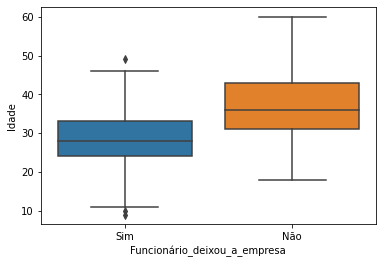

In [36]:
sns.boxplot( x = "Funcionário_deixou_a_empresa", y = "Idade", data = data)

In [37]:
r_quad(data,"Funcionário_deixou_a_empresa", "Idade")

0.14149311914192386

In [38]:
data['fx_idade'] = data['Idade'].apply( lambda x: '0-24 anos' if x<25 else '25-35 anos' if  x<36  else '36-45 anos' if x<46 else 'acima 45 anos' )
info_value(data,"fx_idade","Funcionário_deixou_a_empresa")[1]

,nao,sim,nao_perc,sim_perc,freq,tx_sim,odds,ln_odds,info_value
fx_idade,,,,,,,,,
0-24 anos,59,74,0.047851,0.312236,133,0.556391,6.525209,1.875673,0.495901
25-35 anos,510,126,0.413625,0.531646,636,0.198113,1.285331,0.251017,0.029625
36-45 anos,425,35,0.344688,0.147679,460,0.076087,0.428444,-0.847596,0.166984
acima 45 anos,239,2,0.193836,0.008439,241,0.008299,0.043536,-3.134171,0.581067


<b>CONCLUSÃO:</b> A Idade explica 14% da diferença entre funcionários que saíram ou ficaram na empresa. Quanto mais jovem, maior a chance de deixar a empresa.

Uma hipotese é que Idade e Estado_Civil estão relacionados. Vamos testar esta hipotese também.

<AxesSubplot:xlabel='Estado_Civil', ylabel='Idade'>

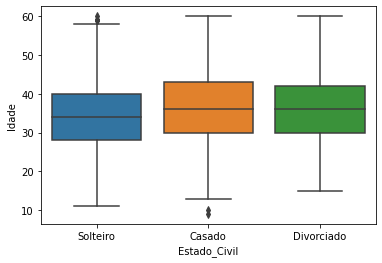

In [39]:
sns.boxplot( x = "Estado_Civil", y = "Idade", data = data)

In [40]:
r_quad(data,"Estado_Civil", "Idade")

0.012998237349271413

Não há uma associação evidente entre estado civil e idade.

* Funcionário_deixou_a_empresa x Distância_do_trabalho

<AxesSubplot:xlabel='Funcionário_deixou_a_empresa', ylabel='Distância_do_trabalho'>

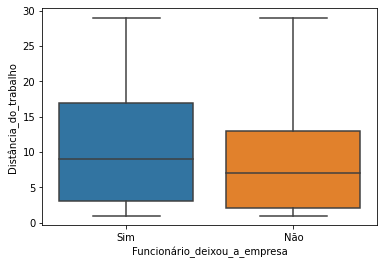

In [41]:
sns.boxplot( x = "Funcionário_deixou_a_empresa", y = "Distância_do_trabalho", data = data)

In [42]:
r_quad(data,"Funcionário_deixou_a_empresa", "Distância_do_trabalho")

0.005344156834171221

<b>CONCLUSÃO:</b> A Idade explica 0,5% da diferença entre funcionários que saíram ou ficaram na empresa. 

* Funcionário_deixou_a_empresa x Salário

<AxesSubplot:xlabel='Funcionário_deixou_a_empresa', ylabel='Salário'>

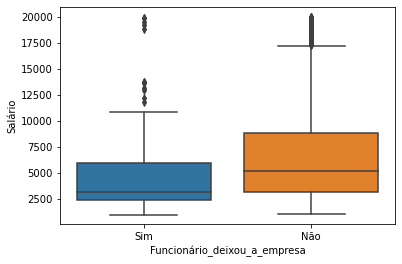

In [43]:
sns.boxplot( x = "Funcionário_deixou_a_empresa", y = "Salário", data = data)

In [44]:
r_quad(data,"Funcionário_deixou_a_empresa", "Salário")

0.025092380919215618

<b>CONCLUSÃO:</b> A Idade explica 2,5% da diferença entre funcionários que saíram ou ficaram na empresa. 

* Funcionário_deixou_a_empresa x Tempo_de_empresa

<AxesSubplot:xlabel='Funcionário_deixou_a_empresa', ylabel='Tempo_de_empresa'>

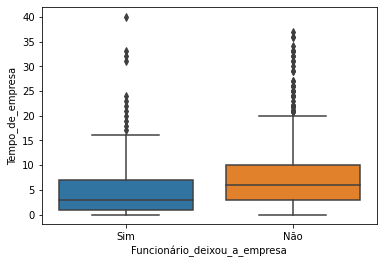

In [45]:
sns.boxplot( x = "Funcionário_deixou_a_empresa", y = "Tempo_de_empresa", data = data)

In [46]:
r_quad(data,"Funcionário_deixou_a_empresa", "Tempo_de_empresa")

0.017414044972456688

<b>CONCLUSÃO:</b> A Idade explica 1,7% da diferença entre funcionários que saíram ou ficaram na empresa. 

# 3. Interpretação para o negócio

## 3.1. Conclusões da análise exploratória

In [47]:
iv_df = iv_df.reset_index()
iv_df = iv_df[["variavel","IV"]].sort_values("IV", ascending=False).reset_index()
iv_df

,index,variavel,IV
0,5,Faz_hora_extras?,0.400183
1,4,Estado_Civil,0.218898
2,0,Frequência de Viagens,0.120868
3,2,E-Sat,0.099886
4,1,Formação,0.016505
5,3,Gênero,0.006496


Variaveis qualitativas associadas ao turnover: 
* Faz_hora_extras?
* Estado_Civil
* Frequência de Viagens

Variaveis quantitativas associadas ao turnover:
* Idade

## 3.2. Plano de ação
<b>Quais políticas/fatores da empresa deveriam mudar de forma a minimizar o turnover?</b>

<b> Faz_horas_extras? </b>
(Hipotese: quem faz horas extras perde em qualidade de vida ou se sente que trabalha muito e não recebe o valor correspondente
| Ação: Reduzir a porcentagem de hora extra)
* Contratar mais funcionários (Como a hora extra tem custo superior e os funcionários que fazem hora extra saem da empresa com mais frequência é provável que seja possível reduzir os custos da empresa mesmo aumentando o quadro de funcionários)
* Automatizar processos repetitivos para aumentar a eficiência da empresa
* Implementar modelo lean em áreas administrativas (assumindo que essa ainda não seja a realidade)
* Ter benefícios que auxilie na qualidade de vida (por exemplo: acesso a academias)

<b> Estado_Civil </b>
(Hipotese: pessoas solteiras estão mais propensas a buscar desafios do que estabilidade | 
Ação: Aumentar o desafio e benefícios de longo prazo)
* Ter metas individuais e definidas de acordo com os objetivos da empresa e pretensões dos funcionários
* Ter cultura de meritocracia (remunerar pela performance) 

<b> Frequência de Viagens </b>
(Hipotese: viagens são cansativas e não prazerosas | 
Ação: diminuir frequência de viagens, melhorar qualidade das viagens)
* Reavaliar motivos de viagens e criar sistema misto que permita a interação com partes interessadas através de meios digitais
* Garantir tempo de descanso após viagens com mais de 3 dias de duração
* Fazer acordo com rede de hoteis para garantir conforto de hospedagem no tempo de viagem
* Honrar com as despesas de alimentação e transporte do funcionário durante tempo de viagem 
* Permitir aos viajantes tempo para turismo em suas viagens

<b> Idade </b>
(Hipotese: pessoas solteiras estão mais propensas a buscar desafios do que estabilidade | 
Ação: Aumentar o desafio e benefícios de longo prazo)
* Incluir no plano de benefícios atividades que agradem os mais jovens (academia, horário flexível, home office, dress code menos rígido)
* Criar áreas de lazer e descanso internas a empresa para tornar o ambiente menos rígido
* Criar grupos de discussão para temas ESG (assumindo que hoje os jovens são muito mais motivados pelo propósito)
* Traçar planos de carreiras
* Ter plano de formação e treinamento estabelecido 


